In [35]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import lmfit as lm
import pandas as pd

SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [3]:
instability = pd.read_csv("For_Helmut/For_Helmut_1.csv")
instability[:5]

,Age,Instability Mean,Instability Std,Group Size
0,18.0,0.245675,0.006825,5
1,19.0,0.218225,0.005726,3
2,20.0,0.246581,0.011646,3
3,22.0,0.234449,0.008648,3
4,23.0,0.235580,0.004252,5


In [4]:
instability["Instability SE"] = instability["Instability Std"]
instability["Instability Std"] = instability["Instability Std"]*np.sqrt(instability["Group Size"])
instability[:5]

,Age,Instability Mean,Instability Std,Group Size,Instability SE
0,18.0,0.245675,0.015261,5,0.006825
1,19.0,0.218225,0.009917,3,0.005726
2,20.0,0.246581,0.020172,3,0.011646
3,22.0,0.234449,0.014978,3,0.008648
4,23.0,0.235580,0.009508,5,0.004252


In [57]:
instability["Group Size"].sum()

634

<ErrorbarContainer object of 3 artists>

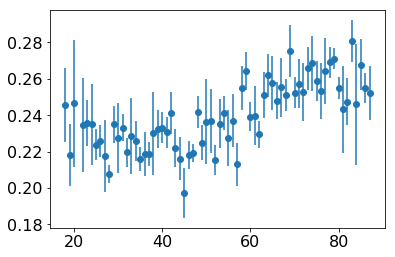

In [5]:
plt.errorbar(instability["Age"],
             instability["Instability Mean"],
             yerr=3*instability["Instability SE"],
             fmt="o")

In [6]:
def sigmoid(x,off,ampl,switchpoint,width):
    return off + ampl/(1+np.exp(-(x-switchpoint)/width))

In [7]:
sigmoid_Model = lm.Model(sigmoid)
pars = sigmoid_Model.make_params()
pars['off'].set(value=instability["Instability Mean"].min(),vary=True)
pars['ampl'].set(value=instability["Instability Mean"].max()-instability["Instability Mean"].min(),vary=True)
pars['switchpoint'].set(value=50,vary=True)
pars['width'].set(value=.1,vary=True)

out = sigmoid_Model.fit(instability["Instability Mean"], pars, x=instability["Age"], weights=1/instability["Instability Std"])
print(out.fit_report(min_correl=0.25))

[[Model]]
    Model(sigmoid)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 91
    # data points      = 69
    # variables        = 4
    chi-square         = 69.4089888
    reduced chi-square = 1.06783060
    Akaike info crit   = 8.40778146
    Bayesian info crit = 17.3442075
[[Variables]]
    off:          0.22336926 +/- 0.00208459 (0.93%) (init = 0.1973084)
    ampl:         0.03689266 +/- 0.00399130 (10.82%) (init = 0.08328854)
    switchpoint:  60.0793202 +/- 1.96727703 (3.27%) (init = 50)
    width:        4.32638938 +/- 1.85545454 (42.89%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.250)
    C(off, ampl)        = -0.640
    C(ampl, width)      =  0.605
    C(off, width)       = -0.434
    C(off, switchpoint) =  0.290



In [44]:
switchpoint = out.params['switchpoint'].value
width = out.params['width'].value
off = out.params['off'].value
ampl = out.params['ampl'].value
interval_90=np.log((1-0.05)/0.05)
afrom = (switchpoint-interval_90*width,0.19)
ato = (switchpoint+interval_90*width,0.19)
print(interval_90*width)

12.738789536525108


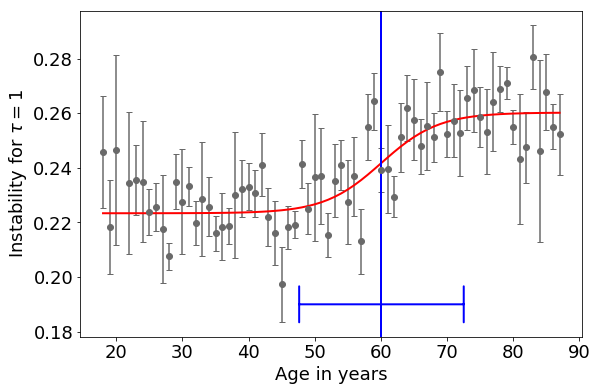

In [56]:
plt.figure(figsize=(9,6))
plt.errorbar(instability["Age"],
             instability["Instability Mean"],
             yerr=3*instability["Instability SE"],
             fmt="o",
             color="dimgrey",
#             alpha=0.5,
            capsize=3)
#plt.plot(instability_clean["Age"], out.init_fit, 'k--')
plt.plot(instability["Age"], out.best_fit, 'r-',linewidth=2)
plt.xlabel("Age in years")
plt.ylabel(r"Instability for $\tau=1$")
plt.annotate(s='', xy=afrom, xytext=ato, arrowprops=dict(arrowstyle='|-|',linewidth=2,color="b"))
plt.axvline(x=switchpoint, color ='b',linewidth=2)
plt.savefig("Instability_tau_1_3SE.png")

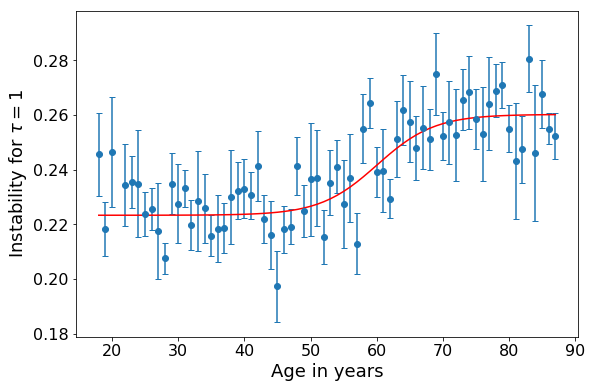

In [9]:
plt.figure(figsize=(9,6))
plt.errorbar(instability["Age"],
             instability["Instability Mean"],
             yerr=instability["Instability Std"],
             fmt="o",
             capsize=3)
#plt.plot(instability_clean["Age"], out.init_fit, 'k--')
plt.plot(instability["Age"], out.best_fit, 'r-')
plt.xlabel("Age in years")
plt.ylabel(r"Instability for $\tau=1$")
plt.savefig("Instability_tau_1_SD.png")

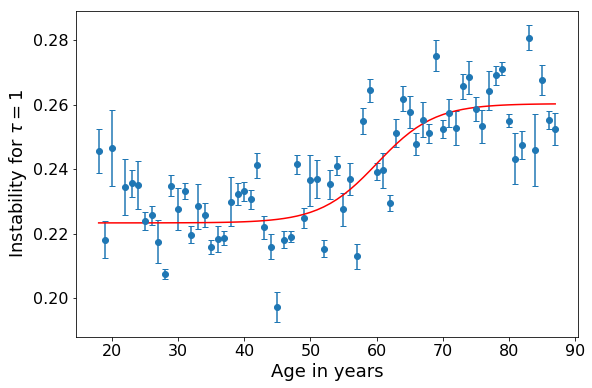

In [10]:
plt.figure(figsize=(9,6))
plt.errorbar(instability["Age"],
             instability["Instability Mean"],
             yerr=instability["Instability SE"],
             fmt="o",
            capsize=3)
#plt.plot(instability_clean["Age"], out.init_fit, 'k--')
plt.plot(instability["Age"], out.best_fit, 'r-')
plt.xlabel("Age in years")
plt.ylabel(r"Instability for $\tau=1$")
plt.savefig("Instability_tau_1_SE.png")

In [11]:
linmod = lm.models.LinearModel()
linpars = linmod.guess(instability["Instability Mean"], x=instability["Age"])
outlin = linmod.fit(instability["Instability Mean"],linpars,x=instability["Age"],weights=1/instability["Instability Std"])
print(outlin.fit_report(min_correl=0.25))                    

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6
    # data points      = 69
    # variables        = 2
    chi-square         = 93.2197317
    reduced chi-square = 1.39133928
    Akaike info crit   = 24.7588507
    Bayesian info crit = 29.2270637
[[Variables]]
    intercept:  0.20069791 +/- 0.00409569 (2.04%) (init = 0.2064562)
    slope:      6.9641e-04 +/- 7.3325e-05 (10.53%) (init = 0.0006308851)
[[Correlations]] (unreported correlations are < 0.250)
    C(intercept, slope) = -0.931



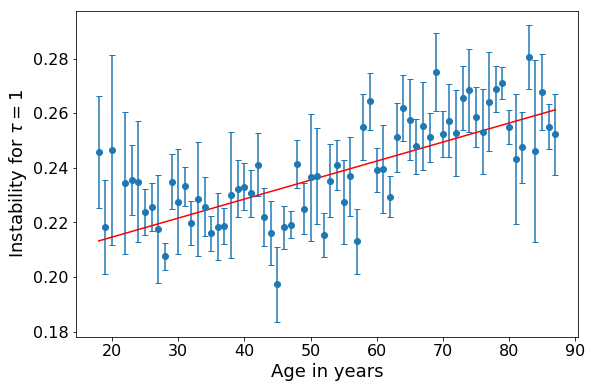

In [12]:
plt.figure(figsize=(9,6))
plt.errorbar(instability["Age"],
             instability["Instability Mean"],
             yerr=3*instability["Instability SE"],
             fmt="o",
            capsize=3)
#plt.plot(instability_clean["Age"], out.init_fit, 'k--')
plt.plot(instability["Age"], outlin.best_fit, 'r-')
plt.xlabel("Age in years")
plt.ylabel(r"Instability for $\tau=1$")
plt.savefig("Instability_tau_1_3SE_lin.png")

In [51]:
(1.39133928-1.06783060)/1.06783060

0.30295880264154257